# Projeto 3 -  Clusterização

## Informações do Projeto
DataSet:<br /><br />https://www.kaggle.com/new-york-city/nyc-property-sales
     nyc-property-sales

Grupo:
      Antonio Andraues<br />
      Lucca Delchiaro <br/ >
      Joao Edvirges.<br /><br />


In [72]:
import math
import pandas as pd
import json
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from matplotlib import cm
import numpy as np
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.stats import *
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from sklearn.mixture import GMM

import numpy as np
import statsmodels.api as sm

In [165]:
dados=pd.read_csv("nyc-rolling-sales.csv")
dados.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [177]:
dados2=dados.loc[:,['NEIGHBORHOOD','SALE PRICE','BLOCK','TAX CLASS AT PRESENT','GROSS SQUARE FEET','LAND SQUARE FEET','YEAR BUILT']] #selecionando os subsets que vamos trabalhar
dados2=dados2.rename(columns={'SALE PRICE': 'SALE_PRICE',
                              'TAX CLASS AT PRESENT': 'TAX_CLASS_AT_PRESENT',
                              'GROSS SQUARE FEET': 'GROSS_SQUARE_FEET',
                              'LAND SQUARE FEET': 'LAND_SQUARE',
                              'YEAR BUILT': 'YEAR_BUILT'})#facilitar a representacao da coluna


dados2=dados2.loc[dados2.SALE_PRICE!=' -  ']#retirada do formato "Nao completado"
dados2=dados2.loc[dados2.GROSS_SQUARE_FEET!=' -  ']#retirada do formato "Nao completado"
dados2=dados2.loc[dados2.LAND_SQUARE!=' -  ']#retirada do formato "Nao completado"

dados2.SALE_PRICE=dados2.SALE_PRICE.astype("float") #Troca dos valores de string para float
dados2.GROSS_SQUARE_FEET=dados2.GROSS_SQUARE_FEET.astype("float") #Troca dos valores de string para float
dados2.LAND_SQUARE=dados2.LAND_SQUARE.astype("float") #Troca dos valores de string para float
dados2.YEAR_BUILT=dados2.YEAR_BUILT.astype("int") #Troca dos valores de string para int



dados2=dados2.loc[dados2.TAX_CLASS_AT_PRESENT!='3'] #Segundo o dataset, os valores representados por 3 e 4 representam
dados2=dados2.loc[dados2.TAX_CLASS_AT_PRESENT!='4'] #Fabricas e terrenos vazios, logo retiramos esses valores da analise

dados2.SALE_PRICE=dados2.SALE_PRICE.loc[dados2.SALE_PRICE>=30000] #Retirando casas muito baratas 
dados2.SALE_PRICE=dados2.SALE_PRICE.loc[dados2.SALE_PRICE<=10000000] #Retirando casas acima do valor de 1bilhao de dollares
dados2=dados2.loc[dados2.GROSS_SQUARE_FEET<=10000]#outliers
dados2=dados2.loc[dados2.GROSS_SQUARE_FEET>0]#NO SENSE
dados2=dados2.loc[dados2.LAND_SQUARE<=20000]#outliers 
dados2=dados2.loc[dados2.YEAR_BUILT>0]#NO SENSE

dados2=dados2.dropna() #Retirada dos nan
dados2=dados2.reset_index() #Re indexando para facilitar o shuffle e a selecao de index
dados2 = shuffle(dados2)  #Shuffle dos dados para separarmos de maneira aleatoria dois diferentes grupos.
dados2=dados2.reset_index()
dados2.head(5)


,level_0,index,NEIGHBORHOOD,SALE_PRICE,BLOCK,TAX_CLASS_AT_PRESENT,GROSS_SQUARE_FEET,LAND_SQUARE,YEAR_BUILT
0,3456,25374,BATH BEACH,748000.0,6461,1,928.0,1649.0,1940
1,16627,66747,MASPETH,640000.0,2382,1,1408.0,2400.0,1930
2,2230,22605,PELHAM PARKWAY SOUTH,700000.0,4326,1,2437.0,3053.0,1920
3,21190,75522,WOODHAVEN,645000.0,8905,1,2248.0,2500.0,1910
4,15976,63874,JACKSON HEIGHTS,1300000.0,1167,1,2422.0,1967.0,1960


In [182]:
pe=len(dados2)*0.8 #Separacao do Training e do test dataset!
pe1=len(dados2)*0.2

print("valores de quantos index possuem em cada dataset: TRANING={0}  TEST={1}".format(pe,pe1))

dados80=dados2.head(20908)#Separacao do Training 
dados20=dados2.tail(5227)#Separacao do Test

valores de quantos index possuem em cada dataset: TRANING=20908.0  TEST=5227.0


Essa parte do codigo foi comentada, uma vez que nao servia para analize dos nossos dados(Estava relaciona diretamente a nossa intencao de fazer um cluster)
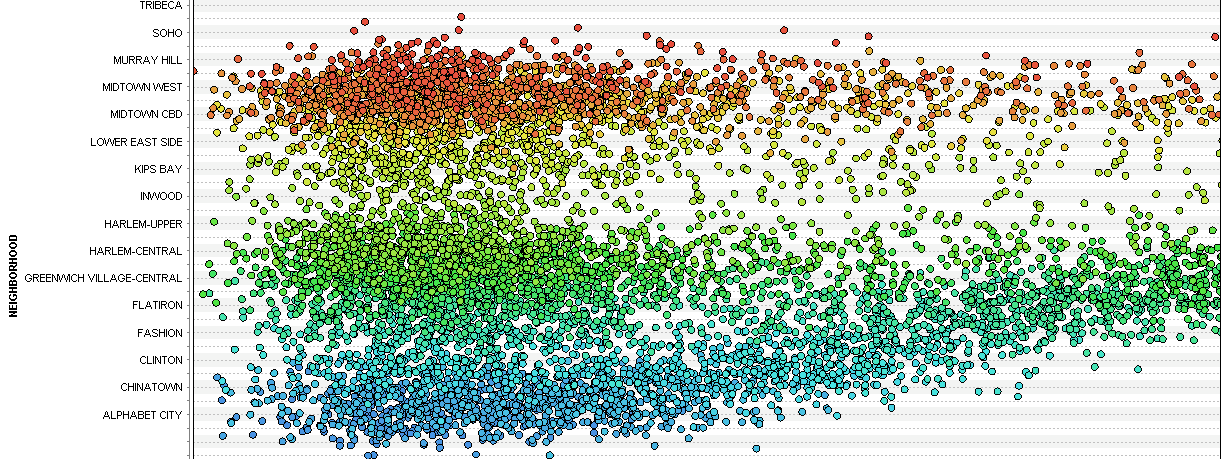

Percebemos apartir de um um sample dos dados(relacionados a uma parte dos bairro), que nao consiquiriamos fazer o cluster, e percebemos algumas outras oportunidades na regressao!

In [181]:
n=3 #numeros de bairros
bairros = dados2.NEIGHBORHOOD[~dados2.NEIGHBORHOOD.duplicated(keep='first')] #Nomes de todos os bairros uma unica vez
primeirosB=bairros[:n] #primeiros 10 bairros para analize
primeirosBairros=[] #colocando os nomes em uma lista
for i in primeirosB:
    primeirosBairros.append(i)
        
Precos=[]         #pegando os precos para cada bairro
for u in primeirosBairros:  
    ppp=dados2.loc[dados2.NEIGHBORHOOD==u]
    pp=ppp  #Serve para analizar cada bairro individualmente
    for c in range(0,len(ppp)):
        preco=ppp.SALE_PRICE
    Precos.append(preco)
# dados2.plot.scatter(x='LAND_SQUARE_FEET',y='BLOCK',z='SALE_PRICE',norm=1)

# dd=pd.DataFrame(Precos,columns=[primeirosBairros]) #Gerado randomicamente so para teste    

# Plot
# fig, ax = plt.subplots()
# ax.legend()

# plt.show()

# dd=pd.DataFrame(np.random.rand(len(preco), n),columns=[primeirosBairros]) #Gerado randomicamente so para teste
# print(dd.max())

# ax = dd.plot.scatter(x=primeirosBairros[0], y=primeirosBairros[0], color='DarkBlue', label=primeirosBairros[0]);
# dd.plot.scatter(x=primeirosBairros[1], y=primeirosBairros[1], color='DarkGreen', label=primeirosBairros[1], ax=ax);

# plt.show()



# REGRESSAO

formula: y = -4.786991366705265e-05x + 13.627746099729762


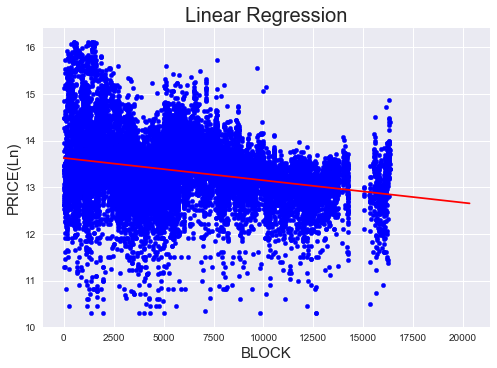

In [188]:

df4 = pd.DataFrame()
df4['BLOCK'] = dados80.BLOCK   #Primeira variavel a ser interpretada
df4['PRICE'] = np.log(dados80.SALE_PRICE) #O preco sera em todas as regressoes a principal variavel que queremos prever
mdl = linear_model.LinearRegression().fit(df4[['BLOCK']],df4['PRICE'])
m = mdl.coef_[0]  #Os coeficientes e o intercept nao serao unicamente descobertos por meio da funcao!
b = mdl.intercept_
print("formula: y = {0}x + {1}".format(m, b))
df4.plot.scatter(x='BLOCK',y='PRICE',color='blue')
lista=[]
t=[]
for i in range (max(df4.BLOCK)+4000): # Aqui neste "for" acrescentamos um valor fixo de blocks para nossa previsao!mais 4000!
    lista.append(m*i+b)                  #Dois quais representariam bairros posssivelmente mais distantes da marca inicial adotada
    t.append(i) #Lembrando de acrescentar em uma lista para o plot da reta!
plt.plot(t,lista,'r') 
plt.title('Linear Regression', fontsize = 20)
plt.xlabel('BLOCK', fontsize = 15)
plt.ylabel('PRICE(Ln)', fontsize = 15) #Utilizamos o Ln para melhorar a escala! e facilitar a visualizacao da nossa regressao!
plt.show()


In [189]:
X = df4['PRICE']
Y = df4["BLOCK"]
Y = sm.add_constant(Y)
model = sm.OLS(X,Y)
results1 = model.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     1626.
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        21:18:12   Log-Likelihood:                -20563.
No. Observations:               20908   AIC:                         4.113e+04
Df Residuals:                   20906   BIC:                         4.115e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6277      0.008   1671.753      0.000      13.612      13.644
BLOCK      -4.787e-05   1.19e-06    -40.326      0.000   -5.02e-05   -4.55e-05
==============================================================================
Omnibus:                     1075.670   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3966.627
Skew:                          -0.108   Prob(JB):                         0.00
Kurtosis:                       5.123   Cond. No.                     1.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Como não tinhamos experiencia com o OLS, decidimos calcular os valores utilizando as formulas em si para ver se o ele realmente se adapta ao nosso modelo


In [79]:
my = df4['PRICE'].mean()
mx = df4['BLOCK'].mean()
Sxy = 0
Sxx = 0
SSr =0 
for i in range(len(df4)):
    Sxy += (df4['BLOCK'][i] - mx)*(df4['PRICE'][i] - my)
    Sxx += (df4['BLOCK'][i] - mx)**2
    SSr +=  (df4['PRICE'][i] - my)**2
B1 = Sxy/Sxx

Bo = my - B1*mx
print(my,mx)
print('Sxy é {}'.format(Sxy))
print('Sxx é {}'.format(Sxx))
print('Beta 0 é {}'.format(Bo))
print('Beta 1 é {}'.format(B1))

13.35585916209343 5718.710971876793
Sxy é -13964244.173912449
Sxx é 296071375592.40247
Beta 0 é 13.625582894121003
Beta 1 é -4.716512748310002e-05


In [80]:
SSe = 0
n = len(df4)
for i in range(len(df4)):
    SSe += (df4['PRICE'][i] - (Bo + B1*df4['BLOCK'][i]))**2
    
dpestimado = (SSe/(n-2))**0.5
print('σ̂ é o desvio padrão estimado : {}'.format(dpestimado))
dpestimadoBo = dpestimado*(1/n + (mx)**2/Sxx)**0.5
dpestimadoB1 = dpestimado/(Sxx)**0.5
print('σ̂ β0 é o desvio padrão estimado de β0 : {}'.format(dpestimadoBo))
print('σ̂ β1 é o desvio padrão estimado de β1 : {}'.format(dpestimadoB1))

σ̂ é o desvio padrão estimado : 0.6466514661701346
σ̂ β0 é o desvio padrão estimado de β0 : 0.008135668777081677
σ̂ β1 é o desvio padrão estimado de β1 : 1.1884257571688296e-06


Percebemos aqui que o σ̂ β0 e o σ̂ β1 coincidem com o do OLS

Exemplo do amostral    20%:



formula: y = -4.716512748309975e-05x + 13.625582894120962


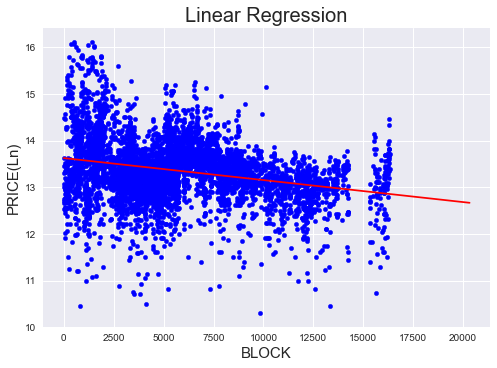

In [81]:
df42 = pd.DataFrame() 
df42['BLOCK'] = dados20.BLOCK
df42['PRICE'] = np.log(dados20.SALE_PRICE)
print("formula: y = {0}x + {1}".format(m, b))
df42.plot.scatter(x='BLOCK',y='PRICE',color='blue')
lista=[]
t=[]
for i in range (max(df42.BLOCK)+4000):
    lista.append(m*i+b)
    t.append(i)
plt.plot(t,lista,'r')
plt.title('Linear Regression', fontsize = 20)
plt.xlabel('BLOCK', fontsize = 15)
plt.ylabel('PRICE(Ln)', fontsize = 15)
plt.show()


Histograma de erros com o amostral:

$$e=(\hat{y}-yi)$$

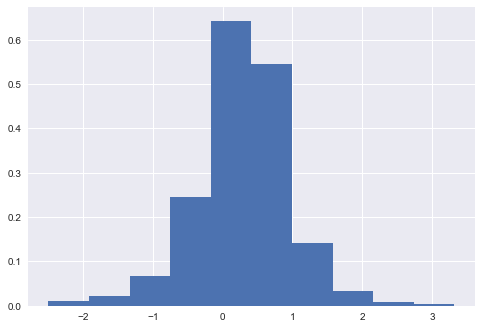

In [82]:
E =  (m+b) - df42.PRICE
E.hist(normed=True)

In [217]:
df = pd.DataFrame()
@interact(rodar_em_x = (0, 360, 20),rodar_em_y = (0, 360, 20))
def f(rodar_em_x=40,rodar_em_y=60):
    df['GSF'] = dados80.GROSS_SQUARE_FEET*10**3
    df['BLOCK'] = dados80.BLOCK
    df['PRICE'] = np.log(dados80.SALE_PRICE)
    threedee = plt.figure().gca(projection='3d')
    threedee.scatter(df.GSF, df.BLOCK, df.PRICE,c='blue',
           marker='o',
           alpha=0.2)
    threedee.set_xlabel('GROSS_SQUARE_FEET')
    threedee.set_ylabel('BLOCK')
    threedee.set_zlabel('PRICE')
    threedee.view_init(rodar_em_x,rodar_em_y )
    plt.show()
#     x_surf = np.arange(0, max(df["GSF"]),max(df["GSF"])*0.15)                
#     y_surf = np.arange(0, max(df["BLOCK"]),max(df["BLOCK"])*0.15)
#     x_surf, y_surf = np.meshgrid(x_surf, y_surf)
#     exog = pd.core.frame.DataFrame({'GSF': x_surf.ravel(), 'BLOCK': y_surf.ravel()})
#     out = results.predict(exog = exog)
#     threedee.plot_surface(x_surf, y_surf, z_surf,rstride=1,
#                 cstride=1,
#                 color='None',        
#                 alpha = 0.4)         #TENTATIVA DE PLOTAGEM PLANO

In [128]:
Z = df['PRICE']
Y = df[['BLOCK','GSF']]
Y = sm.add_constant(Y)
model = sm.OLS(Z,Y)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     3804.
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        20:32:18   Log-Likelihood:                -18066.
No. Observations:               20908   AIC:                         3.614e+04
Df Residuals:                   20905   BIC:                         3.616e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9415      0.012   1111.324      0.000      12.919      12.964
BLOCK      -2.751e-05   1.09e-06    -25.297      0.000   -2.96e-05   -2.54e-05
GSF         2.755e-07   3.68e-09     74.898      0.000    2.68e-07    2.83e-07
==============================================================================
Omnibus:                     3466.580   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13239.307
Skew:                          -0.797   Prob(JB):                         0.00
Kurtosis:                       6.558   Cond. No.                     6.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Considerando os dados da Tabela OSL(""aproximados, devido a cada shuffle mudarmos os valores"")

Histogrtama de erros com o amostral:

$$e=(\hat{y}-yi)$$

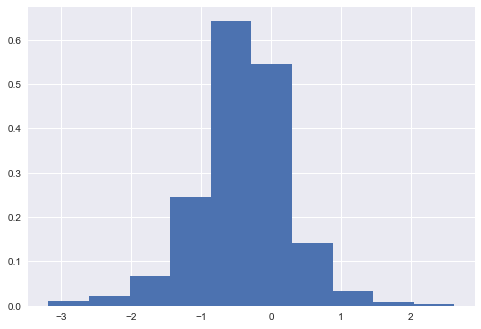

In [207]:
E =  (2.788e-07-2.745e-05+12.9322) - df42.PRICE
E.hist(normed=True)

In [216]:
df2 = pd.DataFrame()
@interact(rodar_em_x = (0, 360, 20),rodar_em_y = (0, 360, 20)) #ROTACAO DO GRAFICO
def f(rodar_em_x=40,rodar_em_y=60):
    df2['LS'] = dados80.LAND_SQUARE
    df2['BL'] = dados80.BLOCK
    df2['SP'] = np.log(dados80.SALE_PRICE)
    threedee = plt.figure().gca(projection='3d')
    threedee.scatter(df2.LS, df2.BL, df2.SP,c='blue',
           marker='o',
           alpha=0.2)
    threedee.set_xlabel('LAND SQUARE')
    threedee.set_ylabel('BLOCK')
    threedee.set_zlabel('SALE PRICE')
    threedee.view_init(rodar_em_x,rodar_em_y )
    plt.show()


In [199]:
Z = df2['SP']
Y = df2[['BL','LS']]
Y = sm.add_constant(Y)

model = sm.OLS(Z,Y)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SP   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     926.8
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        21:23:25   Log-Likelihood:                -20458.
No. Observations:               20908   AIC:                         4.092e+04
Df Residuals:                   20905   BIC:                         4.095e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.5239      0.011   1250.963      0.000      13.503      13.545
BL         -4.989e-05   1.19e-06    -41.948      0.000   -5.22e-05   -4.76e-05
LS          3.887e-05   2.67e-06     14.530      0.000    3.36e-05    4.41e-05
==============================================================================
Omnibus:                     1119.707   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4331.207
Skew:                          -0.096   Prob(JB):                         0.00
Kurtosis:                       5.221   Cond. No.                     1.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Histogrtama de erros com o amostral:

$$e=(\hat{y}-yi)$$

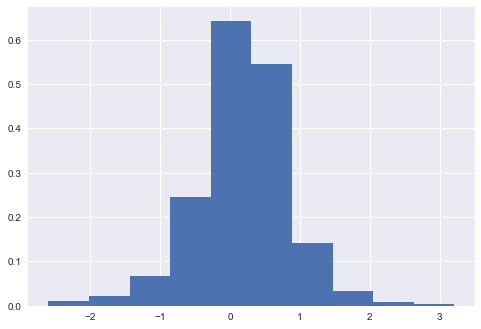

In [209]:
E =  (3.783e-05-4.887e-05+13.5195) - df42.PRICE
E.hist(normed=True)